In [ ]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [ ]:
"hello"

'hello'

In [ ]:
#LOGIN TO HUGGING FACE TO ACCESS DATASET
%pip install --upgrade huggingface_hub
from huggingface_hub import login
login()

In [ ]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

In [ ]:

%pip install datasets
from datasets import load_dataset
dataset_train = load_dataset("roskyluo/stanford_cars_blip",split=['train[0:1000]'])
dataset_valid = load_dataset("roskyluo/stanford_cars_blip",split=['train[1001:1250]'])

In [ ]:
dataset_train = dataset_train[0]

In [ ]:
dataset_valid = dataset_valid[0]

In [ ]:
from torchvision.transforms import Compose, ColorJitter, ToTensor, Normalize, Resize

trainingTransform = Compose(
    [ToTensor(), Resize((128,128)),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
ToTensor = Compose(
    [ToTensor(),Resize((128,128))]
)

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [trainingTransform(image.convert("RGB")) for image in examples["image"]]
    return examples

def notransforms(examples):
  examples["pixel_values"] = [ToTensor(image) for image in examples["image"]]
  return examples

In [ ]:
dataset_train = dataset_train.with_transform(transforms)
dataset_valid = dataset_valid.with_transform(notransforms)

In [ ]:
from torch.utils.data import DataLoader
labels = []
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        # labels.append("0")
        # print(labels)
    pixel_values = torch.stack(images)
    print(labels)
    return {"pixel_values": pixel_values, "labels": labels}
dataloader_train = DataLoader(dataset_train, collate_fn=collate_fn, batch_size=64)
dataloader_valid = DataLoader(dataset_valid, collate_fn=collate_fn, batch_size=64)

In [ ]:
for data in tqdm(dataloader_train):
  print(data['pixel_values'].shape)
  break
for data in tqdm(dataloader_valid):
  print(data['pixel_values'].shape)
  break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#  defining encoder
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=400):
    super().__init__()

    self.Encoder = nn.Sequential(
        nn.Conv2d(3,16, 3, padding=1), # (128,128)
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1, stride=2), #(64,64)
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, padding=1, stride=2), # (32,32)
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, padding=1, stride=2), # (16,16)
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 3, padding=1, stride=2), # (8,8) (8, 8)
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256*8*8, latent_dim),
        nn.ReLU(),
    )
    self.Linear = nn.Sequential(
        nn.Linear(400, 256*8*8),
        nn.ReLU(),
    )
    self.Decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 256, 3, padding=1), # (8, 8)
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, 3, padding=1,
                           stride=2, output_padding=1), # (16, 16)
        nn.ReLU(),
        nn.ConvTranspose2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 3, padding=1,
                           stride=2, output_padding=1), # (32, 32)
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, padding=1,
                           stride=2, output_padding=1), # (64, 64)
        nn.ReLU(),
        nn.ConvTranspose2d(32, 32, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, padding=1,
                           stride=2, output_padding=1), # (128, 128)
        nn.ReLU(),
        nn.ConvTranspose2d(16, 16, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 3, padding=1)
    )

  def forward(self, x):
    output = self.Encoder(x)
    output = self.Linear(output)
    output = output.view(-1,256,8,8)
    output = self.Decoder(output)
    return output

In [ ]:
#Testing size of the auto encoder
print("Here")
Test = AutoEncoder()
x = torch.randn(64,3,128,128)
forward = Test.forward(x)
print(forward.shape)
print("Testing")

In [ ]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, training_loader, validation_loader):
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    }

    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)

    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images in tqdm(dataloader_train):
        #print(images)
        images = images['pixel_values']
        #print(len(images))
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images to device
        #print("Inputy image", images.shape)
        images = images.to(device)
        #  reconstructing images
        output = self.network(images)
        #print("Output Imasge",output.shape, "input", images.shape,"type",type(output))
        #  computing loss
        loss = loss_function(output, images.view(-1, 3, 128, 128))
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images in tqdm(dataloader_valid):
        with torch.no_grad():
          val_images = val_images['pixel_values']
          #  sending validation images to device
          val_images = val_images.to(device)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_images.view(-1, 3, 128, 128))

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      # --------------
      # VISUALISATION
      # --------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

      for test_images in dataloader_valid:
        #  sending test images to device
        test_images = test_images['pixel_values']
        test_images = test_images.to(device)
        with torch.no_grad():
          #  reconstructing test images
          reconstructed_imgs = self.network(test_images)
        #  sending reconstructed and images to cpu to allow for visualization
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()

        #  visualisation
        imgs = torch.stack([test_images.view(-1, 3, 128, 128), reconstructed_imgs],
                          dim=1).flatten(0,1)
        grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
        grid = grid.permute(1, 2, 0)
        plt.figure(dpi=170)
        plt.title('Original/Reconstructed')
        plt.imshow(grid)
        log_dict['visualizations'].append(grid)
        plt.axis('off')
        plt.show()
        break

    return log_dict

  def autoencode(self, x):
    return self.network(x)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

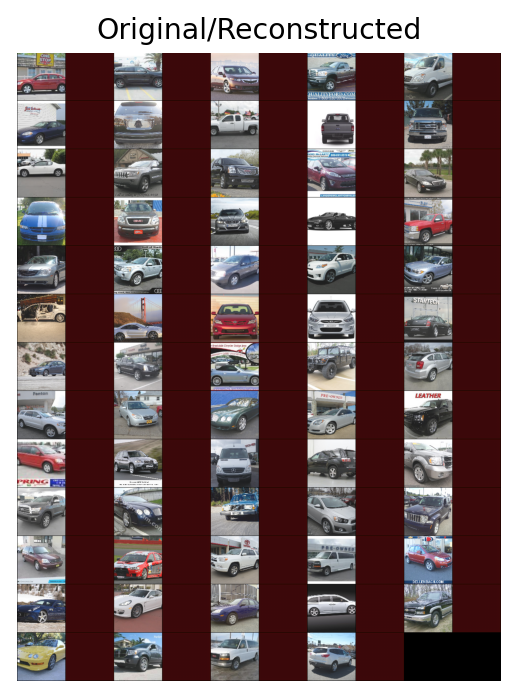

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

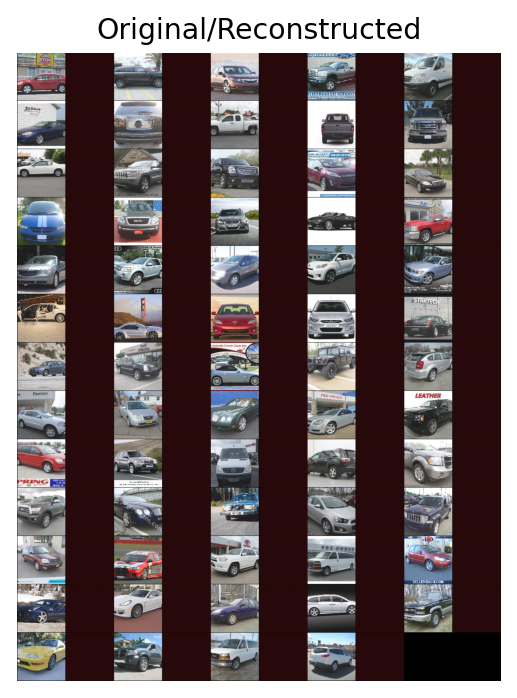

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

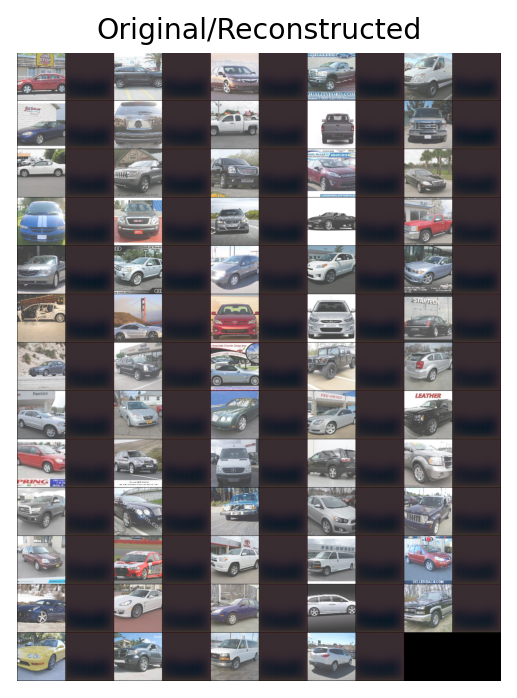

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

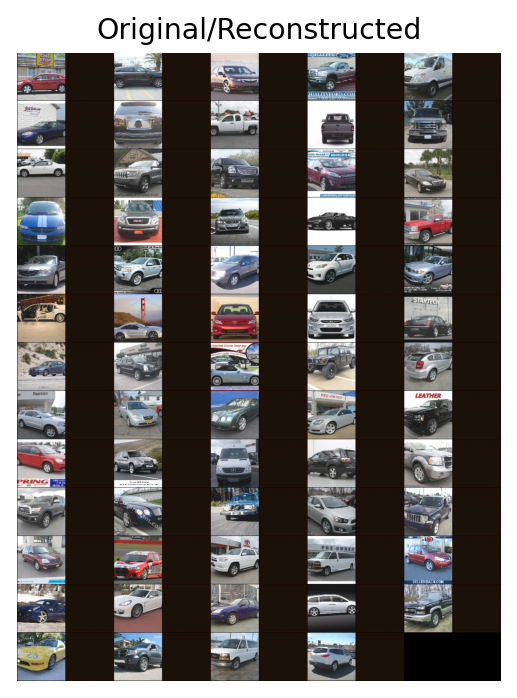

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

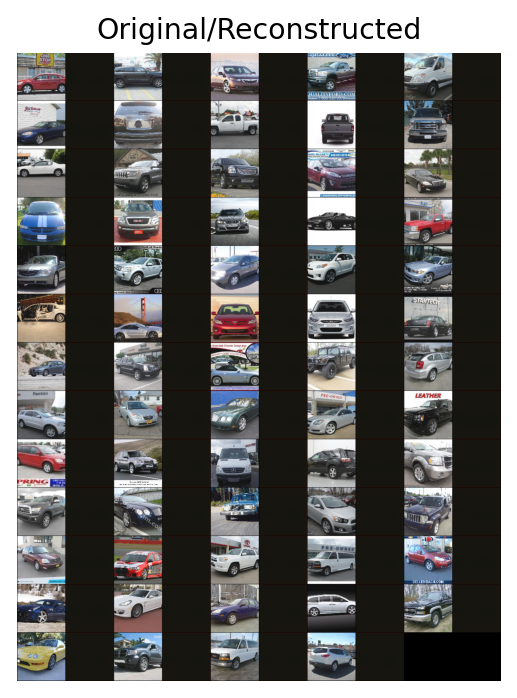

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

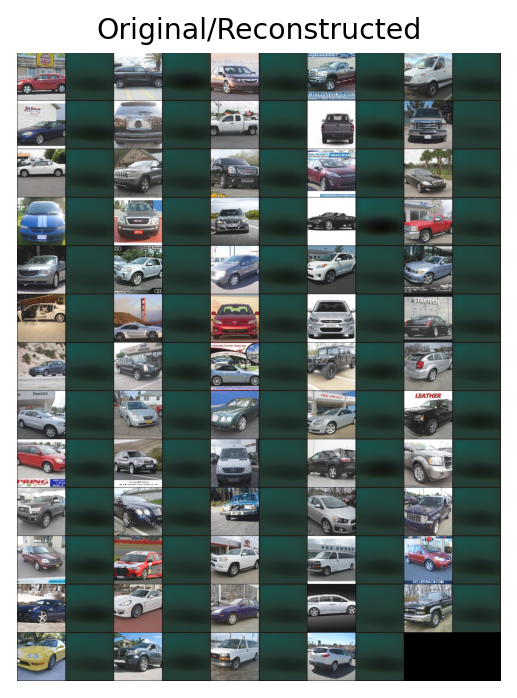

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

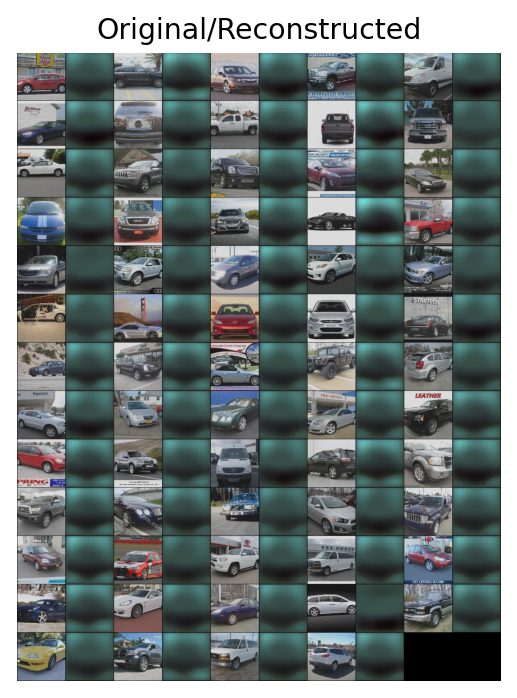

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

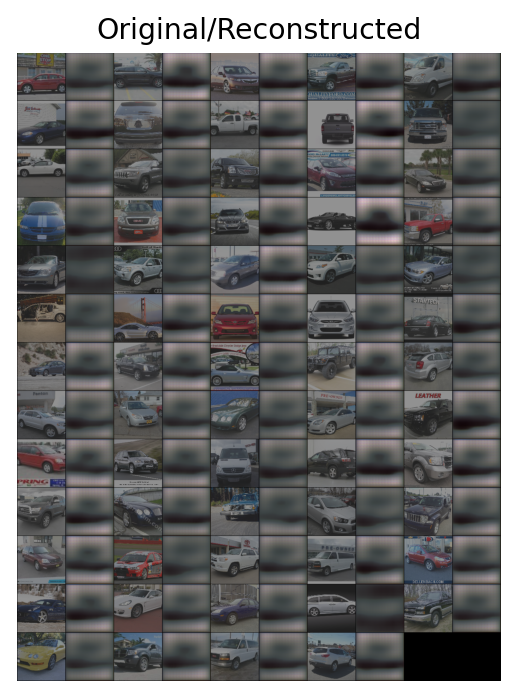

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

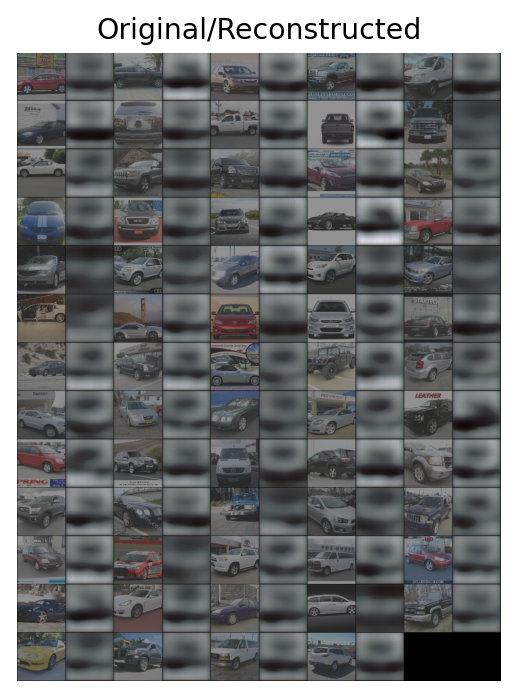

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

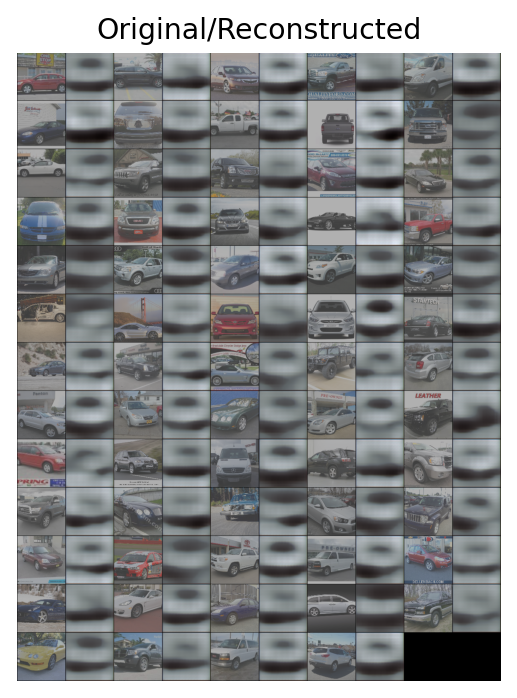

In [ ]:
#  training model
validation_data = 0
test_data = 0
model = ConvolutionalAutoencoder(AutoEncoder())
print(dir(model))
log_dict = model.train(nn.MSELoss(),epochs=10,training_loader=dataloader_train, validation_loader=dataloader_valid)

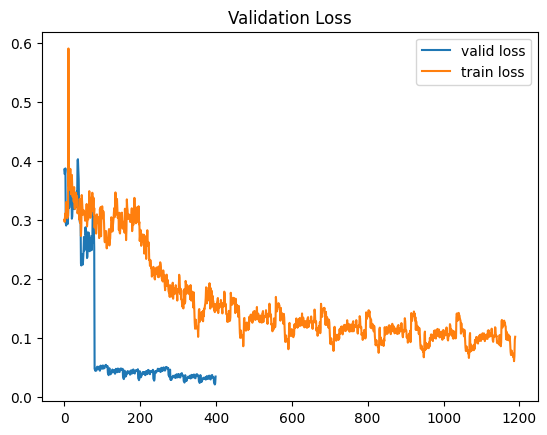

In [ ]:
y1= log_dict['validation_loss_per_batch']
y2 = log_dict['training_loss_per_batch']
plt.plot(y1,label = "valid loss")
plt.plot(y2, label = "train loss")
plt.title("Validation Loss")
plt.legend()